In [1]:
# Code written by Ji Zhang, last modified on 2024-11-08
# For manuscript "Thickness-dependent response of aerosol-jet-printed ultrathin high-aspect-ratio electrochemical microactuators"
# email: zhangji1623316718@gmail.com

import pandas as pd
import os
import numpy as np
import scipy as sp
from scipy import integrate
from scipy.optimize import curve_fit
from scipy.optimize import newton
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
def average(lst):
  return sum(lst)/len(lst)
def sd(lst):
  n = len(lst)
  m = sum(lst)/n
  var = sum((np.array(lst)-m)**2)/n
  return np.sqrt(var)
def sds(lst):
  n = len(lst)
  m = sum(lst)/n
  var = sum((np.array(lst)-m)**2)/(n-1)
  return np.sqrt(var)
class my_dictionary(dict):
  def __init__(self):
    self = dict()
  # Function to add key:value
  def add(self, key, value):
    self[key] = value

# Plot rc parameters adapted from Tom Wade
fig, ax = plt.subplots() # Need to open a 'plot' so that pcParams actually works
plt.close()
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

plt.rcParams.update({
    'font.size': 14,          # controls default text sizes
    'axes.labelsize': 14,     # fontsize of the x and y labels
    'axes.titlesize': 14,     # fontsize of the axes title
    'xtick.labelsize': 14,    # fontsize of the tick labels
    'ytick.labelsize': 14,    # fontsize of the tick labels
    'legend.fontsize': 14,    # fontsize of the legend
    'figure.titlesize': 16,   # fontsize of the figure title
})

current_folder_path = os.getcwd().replace('\\', '/')
print(current_folder_path)

c:/Users/jz495/OneDrive - University of Cambridge/Papers/Soft Matter/Zhang_et_al_data/Actuation/DC length dependence


In [2]:
def get_df(folder_IV_path, folder_def_path, startwith):
    for filename1 in os.listdir(folder_def_path):
        # if True:
        if filename1.startswith(startwith):
            filedef = os.path.join(folder_def_path, filename1).replace('\\', '/')
            for filename2 in os.listdir(folder_IV_path):
                if filename2.startswith(filename1[0:4]):
                    fileIV = os.path.join(folder_IV_path, filename2).replace('\\', '/')
                    break
            df1 = pd.read_csv(fileIV, sep='\t', header=None)
            df2 = pd.read_csv(filedef, sep=',', header=None)
            df2[3] = np.arctan(df2[2]/df2[1])
            break
    return df1, df2

def read(df1, df2):
    # df1 = pd.read_csv(fileIV, sep='\t', header=None)
    # df2 = pd.read_csv(filedef, sep=',', header=None)
    ti = df1[0].to_numpy()
    I = df1[2].to_numpy()
    V = df1[3].to_numpy()
    td = df2[0].to_numpy()
    # dx = df2[1].to_numpy()
    # dy = df2[2].to_numpy()
    # d = np.arctan(dy/dx)
    d = df2[3].to_numpy()
    return ti, I, V, td, d

def plot_V_I_def(ti, I, V, td, d):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(20,8), sharex=True, gridspec_kw=dict(height_ratios=[2, 3, 3]))

    ax1.plot(ti, V, color='tab:orange', lw=1)
    ax1.set_ylabel('$V$/V', color='black')
    # ax2.scatter(ti, I, color='blue', marker='o', edgecolors='blue', s=10, alpha=0.5, facecolors="none")
    # ax3.scatter(td, d, color='green', marker='s', edgecolors='green', s=10, alpha=0.5, facecolors="none")
    ax2.plot(ti, I, color='blue', lw=1)
    ax2.set_ylabel('$I$/mA', color='black')
    ax3.plot(td, d, color='green', lw=1)
    
    ax1.axhline(y=0, color='#999999', linestyle='--')
    ax2.axhline(y=0, color='#999999', linestyle='--')

    ax3.set(xlabel='Time/s', ylabel=r'$\theta$/rad')
    ax3.xaxis.label.set_color('black')
    ax3.yaxis.label.set_color('black')

    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)

    ax3.axhline(y=d[3], color='#999999', linestyle='--')
    # remove last tick label for the second subplot
    yticks = ax1.yaxis.get_major_ticks()
    yticks[-1].label1.set_visible(False)
    plt.subplots_adjust(hspace=.0)

    ax1.tick_params(direction='out', length=5, width=1, colors='black')
    ax2.tick_params(direction='out', length=5, width=1, colors='black')
    ax3.tick_params(direction='out', length=5, width=1, colors='black')

    ax1.grid(axis = 'x', which='minor')
    ax2.grid(axis = 'x', which='minor')
    ax3.grid(axis = 'x', which='minor')
    ax1.grid(axis = 'x', which='major')
    ax2.grid(axis = 'x', which='major')
    ax3.grid(axis = 'x', which='major')
    return fig, (ax1, ax2, ax3)

def scatter_V_I_def(ti, I, V, td, d):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(14,7), sharex=True, gridspec_kw=dict(height_ratios=[2, 3, 3, 3]))

    # ax1.scatter(ti, V, color='tab:orange', marker='o', edgecolors='tab:orange', s=10, alpha=0.3, facecolors="none")
    ax1.plot(ti, V, color='tab:orange', lw=1)
    ax1.set_ylabel('$V$/V', color='black')
    ax2.scatter(ti, I, color='blue', marker='o', edgecolors='blue', s=10, alpha=0.3, facecolors="none")
    ax2.set_ylabel('$I$/mA', color='black')
    
    ax1.axhline(y=0, color='#999999', linestyle='--')
    ax2.axhline(y=0, color='#999999', linestyle='--')
    ax3.axhline(y=0, color='#999999', linestyle='--')
    ax3.set_ylabel(r'$Q_{fit}$/mC', color='black')
    
    ax4.scatter(td, d, color='green', marker='s', edgecolors='green', s=10, alpha=0.3, facecolors="none")
    ax4.set(xlabel='Time/s', ylabel=r'$\theta$/rad')
    ax4.xaxis.label.set_color('black')
    ax4.yaxis.label.set_color('black')
    
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)

    ax4.axhline(y=d[1], color='#999999', linestyle='--')
    # remove last tick label for the second subplot
    yticks = ax1.yaxis.get_major_ticks()
    yticks[-1].label1.set_visible(False)
    plt.subplots_adjust(hspace=.0)
    yticks = ax2.yaxis.get_major_ticks()
    yticks[-1].label1.set_visible(False)
    plt.subplots_adjust(hspace=.0)
    yticks = ax3.yaxis.get_major_ticks()
    yticks[-1].label1.set_visible(False)
    plt.subplots_adjust(hspace=.0)

    ax1.tick_params(direction='out', length=5, width=1, colors='black')
    ax2.tick_params(direction='out', length=5, width=1, colors='black')
    ax3.tick_params(direction='out', length=5, width=1, colors='black')
    ax4.tick_params(direction='out', length=5, width=1, colors='black')
    
    return fig, (ax1, ax2, ax3, ax4)

def plot_V_I_Q_def(ti, I, V, td, d):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(20,8), sharex=True, gridspec_kw=dict(height_ratios=[2, 3, 3, 3]))

    ax1.plot(ti, V, color='tab:orange', lw=1)
    ax1.set_ylabel('$V$/V', color='black')
    ax2.plot(ti, I, color='blue', lw=1)
    ax2.set_ylabel('$I$/mA', color='black')
    Q = sp.integrate.cumulative_trapezoid(I, ti, initial=0)
    ax3.plot(ti, Q, color='tab:blue', lw=1)
    
    ax1.axhline(y=0, color='#999999', linestyle='--')
    ax2.axhline(y=0, color='#999999', linestyle='--')
    ax3.axhline(y=0, color='#999999', linestyle='--')
    ax3.set_ylabel(r'$Q_{fit}$/mC', color='black')
    
    ax4.plot(td, d, color='green', lw=1)
    ax4.set(xlabel='Time/s', ylabel=r'$\theta$/rad')
    ax4.xaxis.label.set_color('black')
    ax4.yaxis.label.set_color('black')
    
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)

    ax4.axhline(y=d[3], color='#999999', linestyle='--')
    # remove last tick label for the second subplot
    yticks = ax1.yaxis.get_major_ticks()
    yticks[-1].label1.set_visible(False)
    plt.subplots_adjust(hspace=.0)
    yticks = ax2.yaxis.get_major_ticks()
    yticks[-1].label1.set_visible(False)
    plt.subplots_adjust(hspace=.0)
    yticks = ax3.yaxis.get_major_ticks()
    yticks[-1].label1.set_visible(False)
    plt.subplots_adjust(hspace=.0)

    ax1.tick_params(direction='out', length=5, width=1, colors='black')
    ax2.tick_params(direction='out', length=5, width=1, colors='black')
    ax3.tick_params(direction='out', length=5, width=1, colors='black')
    ax4.tick_params(direction='out', length=5, width=1, colors='black')

    return fig, (ax1, ax2, ax3, ax4), Q

def readSplit(df1, df2, marks):
    
    # marks = [i*interval for i in range(nInterval)]

    df_I = my_dictionary()
    df_d = my_dictionary()
    pd.options.mode.chained_assignment = None
    for i in range(len(marks)-1):
        values_I = df1[(df1[0]>marks[i]) & (df1[0]<marks[i+1])]
        values_d = df2[(df2[0]>marks[i]) & (df2[0]<marks[i+1]-0.12)]
        # print(values_I.iloc[0,2])
        index = values_I.index[0]
        if i!=0:
            for j in range(5):
                if abs(values_I.iloc[0,2])<0.005:
                    values_I.drop([index+j], inplace=True)
                else:
                    break
    
        df_I.add(i, values_I)
        df_d.add(i, values_d)
    timeI = []
    VV=[]
    II=[]
    timed = []
    dd=[]
    for i in range(len(marks)-1):
        timeI.append(df_I[i][0].to_numpy()-marks[i])
        VV.append(df_I[i][3].to_numpy())
        II.append(df_I[i][2].to_numpy())
        timed.append(df_d[i][0].to_numpy()-marks[i])
        dd.append(df_d[i][3].to_numpy())
    return timeI, VV, II, timed, dd

def readSplitQ(df1, df2, marks):
    
    # marks = [i*interval for i in range(nInterval)]

    df_I = my_dictionary()
    df_d = my_dictionary()
    pd.options.mode.chained_assignment = None
    for i in range(len(marks)-1):
        values_I = df1[(df1[0]>marks[i]) & (df1[0]<marks[i+1])]
        values_d = df2[(df2[0]>marks[i]) & (df2[0]<marks[i+1]-0.12)]
        # print(values_I.iloc[0,2])
        index = values_I.index[0]
        if i!=0:
            for j in range(5):
                if abs(values_I.iloc[0,2])<0.005:
                    values_I.drop([index+j], inplace=True)
                else:
                    break
    
        df_I.add(i, values_I)
        df_d.add(i, values_d)

    timeI = []
    VV=[]
    II=[]
    QQ=[]
    timed = []
    dd=[]
    for i in range(len(marks)-1):
        timeI.append(df_I[i][0].to_numpy())
        VV.append(df_I[i][3].to_numpy())
        II.append(df_I[i][2].to_numpy())
        QQ.append(sp.integrate.cumulative_trapezoid(df_I[i][2].to_numpy(), df_I[i][0].to_numpy(), initial=0))
        timed.append(df_d[i][0].to_numpy())
        dd.append(df_d[i][3].to_numpy())
    return timeI, VV, II, QQ, timed, dd


def plot_part(timeI, VV, II, timed, dd, i):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(20,8), sharex=True, gridspec_kw=dict(height_ratios=[2, 3, 3]))
    ax1.scatter(timeI[i], VV[i], color='tab:orange', marker='o', edgecolors='tab:orange', s=10, alpha=0.3, facecolors="none")
    ax1.set_ylabel('$V$/V', color='black')
    ax2.scatter(timeI[i], II[i], color='blue', marker='o', edgecolors='blue', s=10, alpha=0.3, facecolors="none")
    ax2.set_ylabel('$I$/mA', color='black')
    ax3.scatter(timed[i], dd[i], color='green', marker='s', edgecolors='green', s=10, alpha=0.3, facecolors="none")
    ax3.set(xlabel='Time/s', ylabel=r'$\theta$/rad')
    ax3.xaxis.label.set_color('black')
    ax3.yaxis.label.set_color('black')
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)
    # remove last tick label for the second subplot
    yticks = ax2.yaxis.get_major_ticks()
    yticks[-1].label1.set_visible(False)
    plt.subplots_adjust(hspace=.0)
    ax1.tick_params(direction='out', length=5, width=1, colors='black')
    ax2.tick_params(direction='out', length=5, width=1, colors='black')
    ax3.tick_params(direction='out', length=5, width=1, colors='black')

    ax2.axhline(y=0, color='#999999', linestyle='--')
    # ax3.axhline(y=D, color='#999999', linestyle='--')
    # ax2.plot(timeI[i], Ifit, color='blue', lw=1)
    # ax3.plot(timed[i], dfit, color='green', lw=1)
    return fig, (ax1, ax2, ax3)

In [4]:
def chargeI(x, A1, A2, t1, t2, C): #5 para
    y = A1*np.exp(-x/t1) + A2*np.exp(-x/t2) + C
    return y
# def chargeI(x, A1, A2, t1, t2): #4 para
#     y = A1*np.exp(-x/t1) + A2*np.exp(-x/t2)
#     return y
def chargedef(x, B1, B2, t3, t4, D): #5 para
    y = B1*(1-np.exp(-x/t3)) + B2*(1-np.exp(-x/t4)) + D
    return y
def chargeQ(x, A1, A2, t1, t2):
    y = A1*t1*(1-np.exp(-x/t1)) + A2*t2*(1-np.exp(-x/t2))
    return y

def shortI(x, A1, A2, t1, t2): #4 para
    y = -A1*np.exp(-x/t1) - A2*np.exp(-x/t2)
    return y
def shortdef(x, B1, B2, t3, t4, D): #5 para
    y = B1*np.exp(-x/t3) + B2*np.exp(-x/t4) + D
    return y
def shortQ(x, A1, A2, t1, t2):
    y = -A1*t1*(1-np.exp(-x/t1)) - A2*t2*(1-np.exp(-x/t2))
    return y

def twoExp(x, A1, t1, t2): #3 para
    y = A1*np.exp(-x/t1) + (0.6-A1)*np.exp(-x/t2)
    return y

In [5]:
def remove_background(df2):
    # Get the first and last points
    x_first, y_first = df2.iloc[0, 0], df2.iloc[0, 3]
    x_last, y_last = df2.iloc[-1, 0], df2.iloc[-1, 3]
    
    # Calculate the slope and intercept of the line
    slope = (y_last - y_first) / (x_last - x_first)
    intercept = y_first - slope * x_first
    
    # Subtract the line from the data
    df2[3] = df2[3] - (slope * df2[0] + intercept)
    
    return df2

In [ ]:
## DC chronoamperometry

folder_IV_path = f"{current_folder_path}/IV"
folder_def_path = f"{current_folder_path}/def"

def fitTimesAmps(startwith):
    df1, df2 = get_df(folder_IV_path, folder_def_path, startwith=str(startwith))
    df2 = remove_background(df2)

    if df1[3][2200]>0.1:
        df2[3] = df2[3]-df2[3][10]
    else:
        df2[3] = df2[3][10]-df2[3]
        df1[2] = -df1[2]
        df1[3] = -df1[3]

    ti, I, V, td, d = read(df1, df2)

    marks = [i*50 for i in range(16)]
    timeI, VV, II, timed, dd = readSplit(df1, df2, marks)
    df = pd.DataFrame(columns=['V', 'A1', 'A2', 't1', 't2', 'C', 'B1', 'B2', 't3', 't4', 'D', 'Qp'])

    fig, (ax1, ax2, ax3, ax4) = scatter_V_I_def(ti, I, V, td, d)
    ax4.set_xlim(0,750)

    ax1.text(0.1, 0.5, f'{startwith}', horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes, fontsize=16, color='black')

    Vs=[0.2, 0.4, 0.6, 0.8, 0.6, 0.4, 0.2]

    for i in [1, 3, 5, 7, 9, 11, 13]:
        def fitI(x, A1, A2, t1, t2, C):
            x1 = x[:len(timeI[i])]
            x2 = x[len(timeI[i]):]
            y1 = chargeI(x1, A1, A2, t1, t2, C)
            y2 = shortI(x2, A1, A2, t1, t2)
            return np.concatenate((y1,y2))
        def fitdez(x, B1, B2, t3, t4, D):
            x1 = x[:len(timed[i])]
            x2 = x[len(timed[i]):]
            y1 = chargedef(x1, B1, B2, t3, t4, D)
            y2 = shortdef(x2, B1, B2, t3, t4, D)
            return np.concatenate((y1,y2))

        k = len(df)
        VV = Vs[k]
        paraI, covI = curve_fit(fitI, np.concatenate((timeI[i], timeI[i+1])), np.concatenate((II[i], II[i+1])), p0=[0.2*VV, 0.01*VV, 0.06, 1, 0.0004])
        parad, covd = curve_fit(fitdez, np.concatenate((timed[i], timed[i+1])), np.concatenate((dd[i], dd[i+1])), p0=[0.3*VV, 0.2*VV, 1, 5, -0.05])

        A1, A2, t1, t2, C = paraI
        B1, B2, t3, t4, D = parad
        Q0 = 0

        times = np.arange(0,50,0.2)
        Ifit = chargeI(times, A1, A2, t1, t2,C)
        dfit = chargedef(times, B1, B2, t3, t4, D)
        Qfit = chargeQ(times, A1, A2, t1, t2) + Q0
        Qp = Qfit[-1]

        Ifit2 = shortI(times, A1, A2, t1, t2)
        dfit2 = shortdef(times, B1, B2, t3, t4, D) 
        Qfit2 = shortQ(times, A1, A2, t1, t2) + Qp

        df.loc[k] = [VV, A1, A2, t1, t2, C*100, B1, B2, t3, t4, D, Qp]

        ax2.plot(times+marks[i], Ifit, color='blue', lw=1)
        ax2.plot(times+marks[i+1], Ifit2, color='blue', lw=1)
        ax3.plot(times+marks[i], Qfit, color='tab:blue', lw=1)
        ax3.plot(times+marks[i+1], Qfit2, color='tab:blue', lw=1)
        ax4.plot(times+marks[i], dfit, color='green', lw=1)
        ax4.plot(times+marks[i+1], dfit2, color='green', lw=1)
    # pd.options.display.float_format = "{:.2f}".format
    print(startwith)
    print(df)
    df.to_csv(f'{startwith}output.csv', index=False)
    # plt.savefig(f'{startwith}fittt.png',format='png',dpi=600)
    return df

for i in [6909, 6910, 6912, 6914, 6915, 6916]: #no 6917
    df = fitTimesAmps(i)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(20,8), sharex=True, gridspec_kw=dict(height_ratios=[2, 3, 3, 3]))
for i in [6902, 6904, 6905, 6906, 6907]: 
    df = fitTimesAmps(i)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(20,8), sharex=True, gridspec_kw=dict(height_ratios=[2, 3, 3, 3]))
for i in [6892, 6893, 6894, 6895, 6896, 6897, 6898, 6899]: 
    df = fitTimesAmps(i)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(20,8), sharex=True, gridspec_kw=dict(height_ratios=[2, 3, 3, 3]))
for i in [6882, 6884, 6885, 6887, 6888, 6889, 6890]: 
    df = fitTimesAmps(i)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(20,8), sharex=True, gridspec_kw=dict(height_ratios=[2, 3, 3, 3]))
for i in [6875, 6876, 6877, 6878, 6879, 6880, 6881]: #no 6889
    df = fitTimesAmps(i)

In [ ]:
folder_IV_path = f"{current_folder_path}/IV"
folder_def_path = f"{current_folder_path}/def"

def linear(x, m):
    return m*x

def linear2(x, m, c):
    return m*x + c


def timeFunction(x, A1, A2, t1, t2):
    return A1*np.exp(-x/t1) + A2*np.exp(-x/t2) - 0.1*(A1+ A2)

# larger font in graph
plt.rcParams.update({'font.size': 16})
#larger labels
plt.rcParams.update({'axes.labelsize': 16})


def plotOutput(file, length):
    file = str(file) + 'output.csv'
    df = pd.read_csv(file)

    fig, ((ax1, ax3, ax4, ax6)) = plt.subplots(1, 4, figsize=(16,4))

    # newton rhapson method to find x when time function is 0
    for rows in range(len(df)):
        df.loc[rows, 't_Q'] = fsolve(timeFunction, 0.1, args=(df.loc[rows, 'A1']*df.loc[rows, 't1'], df.loc[rows, 'A2']*df.loc[rows, 't2'], df.loc[rows, 't1'], df.loc[rows, 't2']))
        df.loc[rows, 't_def'] = fsolve(timeFunction, 0.1, args=(df.loc[rows, 'B1'], df.loc[rows, 'B2'], df.loc[rows, 't3'], df.loc[rows, 't4']))
    
    t_Q_mean = np.mean(df['t_Q'].drop(df['t_Q'].idxmax()).drop(df['t_Q'].idxmin()))
    t_def_mean = np.mean(df['t_def'].drop(df['t_def'].idxmax()).drop(df['t_def'].idxmin()))

    ax1.scatter(df['V'], df['t_Q'], color='tab:blue', marker='o', linewidths=1, edgecolors='tab:blue', s=30, alpha=1, facecolors="none", label='Time for 90% charge transfer')
    ax1.set_xlabel('Applied voltage (V)')
    ax1.set_ylabel('Time for 90% charge transfer (s)')
    ax1.xaxis.label.set_color('black')
    ax1.yaxis.label.set_color('black')
    # connect datapoints of 't1' and 't2' with arrowed lines
    for i in range(len(df['V'])-1):
        ax1.annotate("", xy=(df['V'][i], df['t_Q'][i]), xytext=(df['V'][i+1], df['t_Q'][i+1]), arrowprops=dict(arrowstyle="-|>", color='tab:blue'))
    ax1.text(0.5, 0.2, f'mean = {t_Q_mean:.3}', horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes, fontsize=16, color='black')

    ax4.scatter(df['V'], df['t_def'], color='tab:orange', marker='o', linewidths=1, edgecolors='tab:blue', s=30, alpha=1, facecolors="none")
    ax4.set_xlabel('Applied voltage (V)')
    ax4.set_ylabel('Time for 90% deflection (s)')
    ax4.xaxis.label.set_color('black')
    ax4.yaxis.label.set_color('black')
    #connect datapoints of 't3' and 't4' with arrowed lines
    for i in range(len(df['V'])-1):
        ax4.annotate("", xy=(df['V'][i], df['t_def'][i]), xytext=(df['V'][i+1], df['t_def'][i+1]), arrowprops=dict(arrowstyle="-|>", color='tab:blue'))
    ax4.text(0.5, 0.2, f'mean = {t_def_mean:.3}', horizontalalignment='center', verticalalignment='center', transform=ax4.transAxes, fontsize=16, color='black')


    # plot 'Qp' vs 'V'
    ax3.scatter(df['V'], df['Qp'], color='black', marker='o', linewidths=1, edgecolors='black', s=30, alpha=1, facecolors="none")
    ax3.set_xlabel('Applied voltage (V)')
    ax3.set_ylabel('Charge transfer (mC)')
    ax3.xaxis.label.set_color('black')
    ax3.yaxis.label.set_color('black')
    #add a linear fit line through origin using curve_fit
    para, cov = curve_fit(linear, df['V'], df['Qp'])
    m_Q = para[0]
    x = np.linspace(0,0.8,100)
    y = m_Q*x
    # show m on plot
    ax3.text(0.5, 0.9, f'gradient = {m_Q:.3}', horizontalalignment='center', verticalalignment='center', transform=ax3.transAxes, fontsize=16, color='black')
    ax3.plot(x, y, color='green', lw=1)
    #connect datapoints of 'Qp' with arrowed lines
    for i in range(len(df['V'])-1):
        ax3.annotate("", xy=(df['V'][i], df['Qp'][i]), xytext=(df['V'][i+1], df['Qp'][i+1]), arrowprops=dict(arrowstyle="-|>", color='black'))


    # plot 'B1+B2' against 'V' on ax6
    df['B1+B2'] = df['B1']+df['B2']
    ax6.scatter(df['V'], df['B1+B2'] , color='black', marker='o', linewidths=1, edgecolors='black', s=30, alpha=1, facecolors="none")
    ax6.set_xlabel('Applied voltage (V)')
    ax6.set_ylabel('Deflection (rad)')
    ax6.xaxis.label.set_color('black')
    ax6.yaxis.label.set_color('black')
    para, cov = curve_fit(linear, df['V'], df['B1+B2'])
    m_def = para[0]
    x = np.linspace(0,0.8,100)
    ax6.plot(x, m_def*x, color='green', lw=1)
    ax6.text(0.5, 0.9, f'gradient = {m_def:.3}', horizontalalignment='center', verticalalignment='center', transform=ax6.transAxes, fontsize=16, color='black')
    #connect datapoints of 'B1+B2' with arrowed lines
    for i in range(len(df['V'])-1):
        ax6.annotate("", xy=(df['V'][i], df['B1+B2'][i]), xytext=(df['V'][i+1], df['B1+B2'][i+1]), arrowprops=dict(arrowstyle="-|>", color='black'))


    ax1.xaxis.set_major_locator(MultipleLocator(0.2))
    ax1.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax3.xaxis.set_major_locator(MultipleLocator(0.2))
    ax3.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax4.xaxis.set_major_locator(MultipleLocator(0.2))
    ax4.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax6.xaxis.set_major_locator(MultipleLocator(0.2))
    ax6.xaxis.set_minor_locator(MultipleLocator(0.1))

    ax1.set_ylim(bottom=0)
    # ax2.set_ylim(bottom=0)
    ax3.set_ylim(bottom=0)
    ax4.set_ylim(bottom=0)
    # ax5.set_ylim(bottom=0)
    ax6.set_ylim(bottom=0)
    plt.tight_layout()
    # decrease gap between subplots
    # plt.subplots_adjust(wspace=0.3)

    #show file on top of plot
    # print micrometer, not um
    plt.text(2.5, 1.05, f'{length} µm length', horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes, fontsize=17, color='black', fontweight='bold')
    plt.text(0.0, 1.05, f'{file}', horizontalalignment='left', verticalalignment='center', transform=ax1.transAxes, fontsize=16, color='black')
# rewrite above line in bold
    # plt.savefig(f'{file}examples.svg',format='svg')

    return file, m_Q, m_def, t_Q_mean, t_def_mean, length

# create dataframe to store the results
df = pd.DataFrame(columns=['file', 'm_Q', 'm_def', 't_Q_mean', 't_def_mean', 'length'])


for i in [6909, 6912, 6914, 6916]: #no 6910, 6915
    df.loc[len(df)] = plotOutput(i, 1500)

for i in [6904, 6905, 6906, 6907]: #no 6902
    df.loc[len(df)] = plotOutput(i, 2000)

for i in [6893, 6894, 6895, 6897, 6898]: #no 6892, 6896, 6899
    df.loc[len(df)] = plotOutput(i, 2500)

for i in [6882, 6884, 6885, 6887, 6888, 6890]: #no 6889
    df.loc[len(df)] = plotOutput(i, 3500)

for i in [6876, 6877, 6878, 6879, 6880, 6881]: #no 6875
    df.loc[len(df)] = plotOutput(i, 4000)

# save df as csv
df.to_csv('resultsNew.csv', index=False)


0.03923771122243613
28.176613984875203


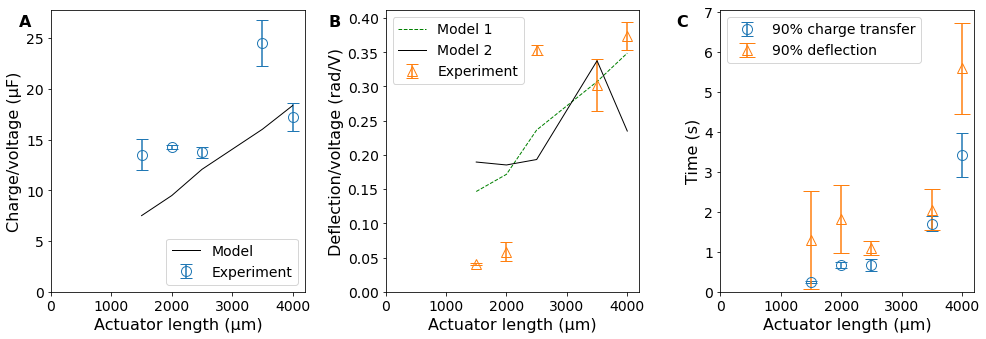

In [8]:
#analysis

n=2.5/7  ##change
w = 0.2 #mm
# l = 3 #mm

# length = [1500, 2000, 2500, 3500, 4000]
PPtop = [1.595275, 1.54255, 1.5933, 1.548775, 1.410925, 1.384]
PPbot = [1.1298, 1.056025, 1.064325, 1.0684, 1.05885, 1.079275]
naf = [5.093495, 5.797125, 5.23685, 5.5748, 5.727625, 5.7842]

df = pd.read_csv('resultsNew.csv')

# ['file', 'm_Q', 'm_def', 't_Q_mean', 't_def_mean', 'length']

df['m_Q'] = abs(df['m_Q'])
df['m_def'] = abs(df['m_def'])
df['t_Q_mean'] = abs(df['t_Q_mean'])
df['t_def_mean'] = abs(df['t_def_mean'])

dfg = df.groupby('length').agg({'m_Q': ['mean', 'std'], 'm_def': ['mean', 'std'], 't_Q_mean': ['mean', 'std'], 't_def_mean': ['mean', 'std']})
dfg['length'] = dfg.index
# print(dfg)
dfg['PPtop'] = [PPtop[int((i-1500)/500)] for i in dfg['length']]
dfg['PPbot'] = [PPbot[int((i-1500)/500)] for i in dfg['length']]
dfg['naf'] = [naf[int((i-1500)/500)] for i in dfg['length']]
dfg['PP'] = 2/(1/dfg['PPtop']+1/dfg['PPbot'])

hP2 = dfg['PPtop'].to_numpy()
hP1 = dfg['PPbot'].to_numpy()
hN = dfg['naf'].to_numpy()
mQ = dfg['m_Q']['mean'].to_numpy()
mdef = dfg['m_def']['mean'].to_numpy()
l = dfg['length'].to_numpy()

hP = 2/(1/hP2+1/hP1)

Cvv = 0.03783770583924643

m2 = hN/hP1
m3 = hP2/hP1
n2 = n
n3 = 1
X12 = m2*n2*(1+m2)*(1/2*Cvv*hP/hP1)
X13 = m3*n3*(1+2*m2+m3)*(1/2*Cvv*hP/hP1 + 1/2*Cvv*hP/hP2)
X23 = m2*n2*m3*n3*(m2+m3)*(1/2*Cvv*hP/hP2)
Y2 = 4*m2*n2+6*m2**2*n2 +4*m2**3*n2+m2**4*n2**2
Y3 = 4*m3*n3+6*m3**2*n3+4*m3**3*n3+m3**4*n3**2
Y23 = m2*m3*n3*((4*m2**2+6*m2*m3+4*m3**2)*n2+12*(1+m2+m3))
coeffDu = 1/6* hP1*(1+Y2+Y3+Y23)/(X12+X13+X23)
l_over_coeffDu = l/(2*coeffDu)
# print(coeffDu)

def fitmdef(l_over_coeffDu, alpha):
    return l_over_coeffDu*alpha

para, cov = curve_fit(fitmdef, l_over_coeffDu, mdef, p0=[20])
alpha1 = para[0]
print(alpha1)

X12 = m2*n2*(1+m2)*(mQ/(w*l*hP1))
X13 = m3*n3*(1+2*m2+m3)*(mQ/(w*l*hP1) + mQ/(w*l*hP2))
X23 = m2*n2*m3*n3*(m2+m3)*(mQ/(w*l*hP2))

coeffDuQ = 1/6* hP1*(1+Y2+Y3+Y23)/(X12+X13+X23)
l_over_coeffDuQ = l/(2*coeffDuQ)
# print(coeffDu)

def fitmdefQ(l_over_coeffDuQ, alpha):
    return l_over_coeffDuQ*alpha

para, cov = curve_fit(fitmdefQ, l_over_coeffDuQ, mdef, p0=[20])
alpha2 = para[0]
print(alpha2)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14,5))
msiz = 10

ax1.errorbar(dfg['length'], 1000*dfg['m_Q']['mean'], yerr=1000*dfg['m_Q']['std'],  fmt='o', mec='tab:blue', mfc='none', ecolor='tab:blue', label='Experiment', capsize=6, capthick=1, markersize=msiz)
ax1.plot([1500, 2000, 2500, 3500, 4000], 1/2*Cvv*w*l*hP, color='black', lw=1, label='Model')
ax1.set_xlabel('Actuator length (μm)')
ax1.set_ylabel('Charge/voltage (μF)')
ax1.set_xlim(0,4200)
ax1.set_ylim(bottom=0)
ax1.legend(loc='lower right')

ax2.errorbar(dfg['length'], dfg['m_def']['mean'], yerr=dfg['m_def']['std'], fmt='^', mec='tab:orange', mfc='none', ecolor='tab:orange', label='Experiment', capsize=6, capthick=1, markersize=msiz)
ax2.set_xlabel('Actuator length (μm)')
ax2.set_ylabel('Deflection/voltage (rad/V)')
ax2.plot([1500, 2000, 2500, 3500, 4000], fitmdef(l_over_coeffDu, alpha1), color='green', label='Model 1', lw=1, linestyle='--')
ax2.plot([1500, 2000, 2500, 3500, 4000], fitmdefQ(l_over_coeffDuQ, alpha2), color='black', label='Model 2', lw=1)
ax2.set_xlim(0, 4200)
ax2.set_ylim(bottom=0)
ax2.legend(loc='upper left')

ax3.errorbar(dfg['length'], dfg['t_Q_mean']['mean'], yerr=dfg['t_Q_mean']['std'], fmt='o', mec='tab:blue', mfc='none', ecolor='tab:blue', label='90% charge transfer', capsize=6, capthick=1, markersize=msiz)
ax3.errorbar(dfg['length'], dfg['t_def_mean']['mean'], yerr=dfg['t_def_mean']['std'], fmt='^', mec='tab:orange', mfc='none', ecolor='tab:orange', label='90% deflection', capsize=8, capthick=1, markersize=msiz)
ax3.set_xlabel('Actuator length (μm)')
ax3.set_ylabel('Time (s)')
ax3.set_xlim(0,4200)
ax3.set_ylim(bottom=0)
ax3.legend()

ax1.text(-0.1, 0.96, 'A', horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes, fontsize=16, color='black', fontweight='bold')
ax2.text(-0.2, 0.96, 'B', horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes, fontsize=16, color='black', fontweight='bold')
ax3.text(-0.15, 0.96, 'C', horizontalalignment='center', verticalalignment='center', transform=ax3.transAxes, fontsize=16, color='black', fontweight='bold')
plt.tight_layout()
# plt.savefig('resultsbothNew.png',format='png',dpi=600)
plt.savefig('resultslength.svg',format='svg')